# Autorisasi Awal

Melakukan mount drive terlebih dahulu, serta mengimport library yang diperlukan

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# this creates a symbolic link
!ln -s /content/drive/MyDrive/ColabNotebooks/ObjectDetection/Skripsi /mydrive

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
import json
import os

# Split Data dengan 5-Fold Cross Validation

CV digunakan sebagai metode validasi dengan tujuan untuk meminimalisasi sampling bias saat menilai evaluasi model. Hal ini dikarenakan jumlah data wilayah studi kasus hanya 312 segmen citra.

Pada pemodelan YOLO, tidak terdapat fungsi untuk melakukan cross validation, sehingga akan dilakukan pemodelan untuk masing-masing  iterasi CV. Dengan demikian data harus dibagi habis menjadi 5 fold, di mana tiap iterasi memiliki pembagian data latih dan data uji yang berbeda, seperti terlihat pada ilustrasi CV berikut.
<div>
<img src="https://drive.google.com/uc?export=view&id=1inbMR5W2DGo67X0SRtPUwY5lDvdd0jZf" width="350"/>
</div>


In [ ]:
jpg_data_path = "/mydrive/data/jpg"
filename = []
region = []

for file in os.listdir(jpg_data_path):
  if file.startswith("pondok"):
    regions = "Pondok"
  if file.startswith("kembangan"):
    regions = "Kembangan"
  if file.startswith("kampung"):
    regions = "Kampung"
  filename.append(file[:-4])
  region.append(regions)
  
frame_all_data = pd.DataFrame({"filename": filename, "region": region})
frame_all_data

,filename,region
0,pondok(3),Pondok
1,pondok(2),Pondok
2,pondok(4),Pondok
3,pondok(5),Pondok
4,pondok(6),Pondok
...,...,...
313,kampung(51),Kampung
314,kampung(52),Kampung
315,kampung(53),Kampung
316,kampung(54),Kampung


Untuk menghindari underestimate atau overestimate pembelajaran dan evaluasi model, maka pada tiap fold juga dipertimbangkan agar memiliki proporsi yang sama antara ketiga wilayah. Dengan demikian, fungsi yang digunakan untuk membagi data adalah ```StratifiedKFold```

In [ ]:
skf = StratifiedKFold(n_splits=5)

X = np.array(filename)
y = np.array(region)
train = []
test = []

for train_index, test_index in skf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  train.append(X_train)
  test.append(X_test)

In [ ]:
all_data_path = "/mydrive/data/all_data"
train_path = "/mydrive/data/train"
test_path = "/mydrive/data/test"

for fold_index, fold in enumerate(train):
  train_folder = "train_" + str(fold_index+1)
  for file in fold:
    shutil.copy(os.path.join(all_data_path, (file + ".jpg")), os.path.join(train_path, train_folder))
    shutil.copy(os.path.join(all_data_path, (file + ".txt")), os.path.join(train_path, train_folder))

for fold_index, fold in enumerate(test):
  test_folder = "test_" + str(fold_index+1)
  for file in fold:
    shutil.copy(os.path.join(all_data_path, (file + ".jpg")), os.path.join(test_path, test_folder))
    shutil.copy(os.path.join(all_data_path, (file + ".txt")), os.path.join(test_path, test_folder))

In [ ]:
from zipfile import ZipFile 
train_name = ["train_1", "train_2", "train_3", "train_4", "train_5"]
test_name = ["test_1", "test_2", "test_3", "test_4", "test_5"]

os.chdir("/mydrive/data/split/")

def GenerateZipFile(ArrayFileName):
  for name in ArrayFileName:
    root_dir = name + "/"
    shutil.make_archive(name,"zip", root_dir)

GenerateZipFile(train_name)
GenerateZipFile(test_name)

In [ ]:
os.chdir("/mydrive/data/split/")
!zip -r "train_1.zip" "train_1/"
!zip -r "train_2.zip" "train_2/"
!zip -r "train_3.zip" "train_3/"
!zip -r "train_4.zip" "train_4/"
!zip -r "train_5.zip" "train_5/"
!zip -r "test_1.zip" "test_1/"
!zip -r "test_2.zip" "test_2/"
!zip -r "test_3.zip" "test_3/"
!zip -r "test_4.zip" "test_4/"
!zip -r "test_5.zip" "test_5/"

# Sebaran Ukuran Bounding Box Objek

Sebaran ukuran tinggi dan lebar dari bounding box bangunan di tiga wilayah dilihat dari statistik deskriptif, kemudian juga dilihat secara visual menggunakan scatter plot dan boxplot. 

Fungsi ```GenerateSizeObject``` di bawah digunakan untuk mengambil ukuran dari bounding box objek bangunan.

In [ ]:
def Convert(string):
    li = list(string.split(" "))
    return li

def GenerateSizeObject(wilayah):
  txt_path = "/mydrive/data/txt"
  build_arr = []
  region = []
  for file in os.listdir(txt_path):
    if file.startswith(wilayah): 
      with open(os.path.join(txt_path, file),'r') as file:
        for string in file:
          line = Convert(string.strip('\n'))
          build_arr.append(line)
          region.append(wilayah)
  new_build_arr = np.array(build_arr)
  data = pd.DataFrame(new_build_arr)
  data.drop(data.columns[[0,1,2]], axis = 1, inplace = True)
  data.rename(columns = {3 : 'rel_width',
                         4 : 'rel_height'}, inplace = True)
  for column in data.columns:
    data[column] = pd.to_numeric(data[column])
  data["width"] = data['rel_width']*256
  data["height"] = data['rel_height']*256
  data["region"] = region
  return data

In [ ]:
pondok_label = GenerateSizeObject("pondok")
kembangan_label = GenerateSizeObject("kembangan")
kampung_label = GenerateSizeObject("kampung")

join = pd.concat([pondok_label, kembangan_label, kampung_label]).reset_index(drop = True)
mapper_daerah = {
    'pondok' : 'Wilayah\nTerjarang',
    'kembangan' : 'Wilayah\nMenengah',
    'kampung' : 'Wilayah\nTerpadat'
}

def coba(daerah):
  return mapper_daerah[daerah]

join['area'] = join['region'].apply(lambda daerah : mapper_daerah[daerah])
join['area'] = join['region'].apply(coba)
join

,rel_width,rel_height,width,height,region,area
0,0.116200,0.204200,29.747200,52.275200,pondok,Wilayah\nTerjarang
1,0.277500,0.192500,71.040000,49.280000,pondok,Wilayah\nTerjarang
2,0.046800,0.069900,11.980800,17.894400,pondok,Wilayah\nTerjarang
3,0.048000,0.155200,12.288000,39.731200,pondok,Wilayah\nTerjarang
4,0.052900,0.154400,13.542400,39.526400,pondok,Wilayah\nTerjarang
...,...,...,...,...,...,...
4231,0.113281,0.183594,28.999936,47.000064,kampung,Wilayah\nTerpadat
4232,0.093750,0.199219,24.000000,51.000064,kampung,Wilayah\nTerpadat
4233,0.058594,0.164062,15.000064,41.999872,kampung,Wilayah\nTerpadat
4234,0.218750,0.121094,56.000000,31.000064,kampung,Wilayah\nTerpadat


In [ ]:
join.describe()

,rel_width,rel_height,width,height
count,4236.000000,4236.000000,4236.000000,4236.000000
mean,0.147212,0.162888,37.686209,41.699391
std,0.077959,0.072274,19.957510,18.502161
min,0.003906,0.003906,0.999936,0.999936
25%,0.093750,0.117188,24.000000,30.000128
50%,0.125000,0.156250,32.000000,40.000000
75%,0.191406,0.199219,48.999936,51.000064
max,1.021000,0.945312,261.376000,241.999872


[Text(0, 0.0, '0.0'),
 Text(0, 0.2, '0.2'),
 Text(0, 0.4, '0.4'),
 Text(0, 0.6000000000000001, '0.6'),
 Text(0, 0.8, '0.8'),
 Text(0, 1.0, '1.0')]

<Figure size 720x432 with 0 Axes>

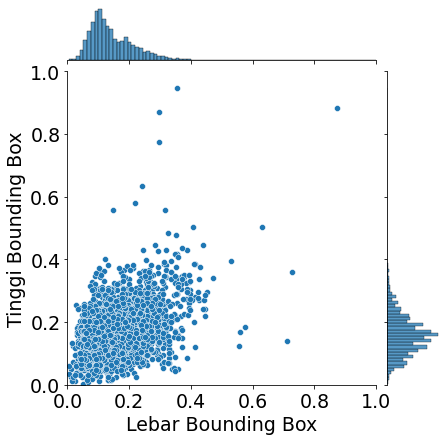

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.jointplot(x="rel_width", y="rel_height", xlim = (0,1), ylim = (0,1), data = join)
ax.set_axis_labels(xlabel='Lebar Bounding Box', ylabel='Tinggi Bounding Box', fontsize=19)
ax.ax_joint.set_xticklabels(ax.ax_joint.get_xticklabels(), fontsize=19)
ax.ax_joint.set_yticklabels(ax.ax_joint.get_yticklabels(), fontsize=19)

<Figure size 720x432 with 0 Axes>

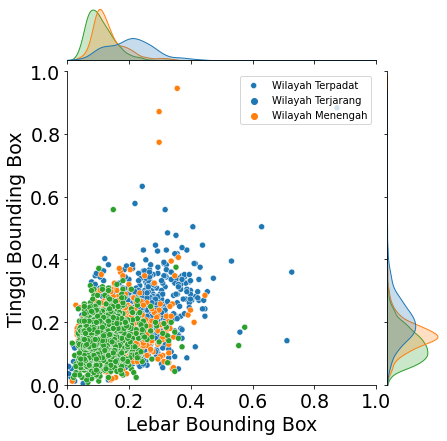

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.jointplot(x="rel_width", y="rel_height", xlim = (0,1), ylim = (0,1), data = join, hue = 'area')
ax.set_axis_labels(xlabel='Lebar Bounding Box', ylabel='Tinggi Bounding Box', fontsize=19)
ax.ax_joint.set_xticklabels(ax.ax_joint.get_xticklabels(), fontsize=19)
ax.ax_joint.set_yticklabels(ax.ax_joint.get_yticklabels(), fontsize=19)
ax.ax_joint.legend(['Wilayah Terpadat', 'Wilayah Terjarang', 'Wilayah Menengah'])

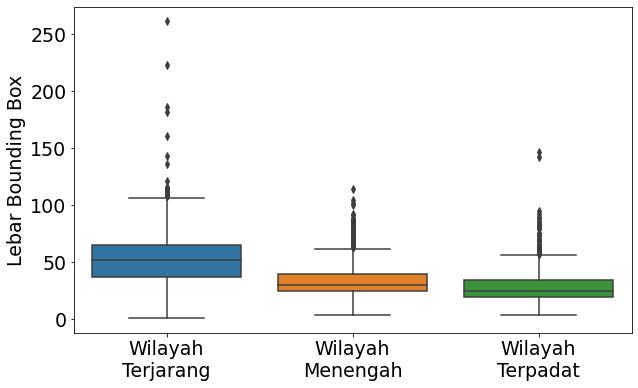

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="area", y='width', data=join)
ax.set_xlabel('')
ax.set_ylabel('Lebar Bounding Box', fontsize=19)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=19)
ax.set_yticks([0, 50, 100, 150, 200, 250])
ax.set_yticklabels([0, 50, 100, 150, 200, 250], fontsize=19);

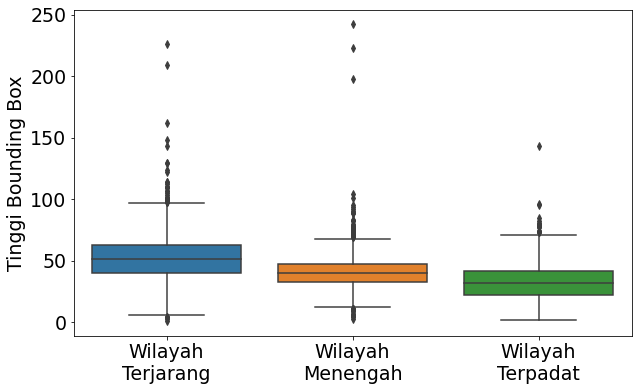

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="area", y='height', data=join)
ax.set_xlabel('')
ax.set_ylabel('Tinggi Bounding Box', fontsize=19)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=19)
ax.set_yticks([0, 50, 100, 150, 200, 250])
ax.set_yticklabels([0, 50, 100, 150, 200, 250], fontsize=19);

## Wilayah Terpadat

,rel_width,rel_height,width,height
count,1546.000000,1546.000000,1546.000000,1546.000000
mean,0.109420,0.130000,28.011643,33.280079
std,0.051670,0.056461,13.227405,14.453982
min,0.015625,0.007812,4.000000,1.999872
25%,0.074219,0.086915,19.000064,22.250112
50%,0.097656,0.125000,24.999936,32.000000
75%,0.132812,0.164062,33.999872,41.999872
max,0.574219,0.558594,147.000064,143.000064


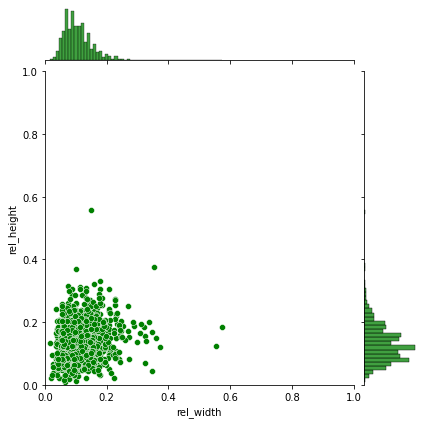

In [ ]:
sns.jointplot(x="rel_width", y="rel_height", xlim = (0,1), ylim = (0,1), color = 'green', data=kampung_label)
#sns.jointplot(x="rel_width", y="rel_height", data=kampung_label, kind='kde')
kampung_label.describe()

## Wilayah Menengah

,rel_width,rel_height,width,height
count,1409.000000,1409.000000,1409.000000,1409.000000
mean,0.134490,0.159912,34.429487,40.937553
std,0.057670,0.060337,14.763505,15.446168
min,0.015625,0.011719,4.000000,3.000064
25%,0.097656,0.128906,24.999936,32.999936
50%,0.117188,0.156250,30.000128,40.000000
75%,0.156250,0.183594,40.000000,47.000064
max,0.445312,0.945312,113.999872,241.999872


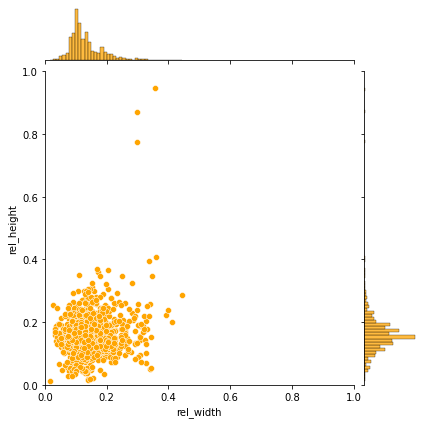

In [ ]:
sns.jointplot(x="rel_width", y="rel_height", xlim = (0,1), ylim = (0,1),color = 'orange', data=kembangan_label)
#sns.jointplot(x="rel_width", y="rel_height", data=kembangan_label, kind='kde')
kembangan_label.describe()

## Wilayah Terjarang

,rel_width,rel_height,width,height
count,1281.000000,1281.000000,1281.000000,1281.000000
mean,0.206814,0.205853,52.944289,52.698365
std,0.088143,0.079162,22.564613,20.265533
min,0.003906,0.003906,0.999936,0.999936
25%,0.144531,0.156250,36.999936,40.000000
50%,0.203125,0.199219,52.000000,51.000064
75%,0.253906,0.246094,64.999936,63.000064
max,1.021000,0.883200,261.376000,226.099200


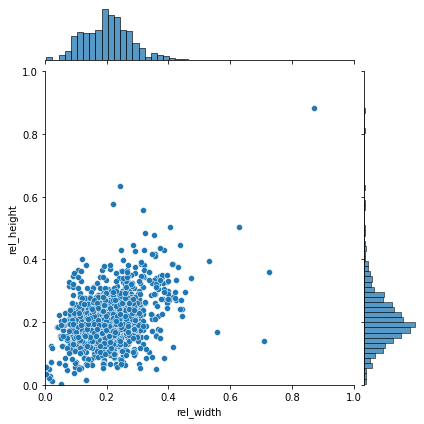

In [ ]:
#sns.jointplot(x="rel_width", y="rel_height", data=pondok_label, kind='kde')
pondok_label.describe()

# Cluster Ukuran Anchors Box

Seperti pada pemodelan pre-trained, pemodelan fine-tuned juga dilihat pengaruh tuning hyperparameter anchors box terhadap kinerja model. Ukuran anchors box dipilih dari titik pusat cluster menggunakan K-Means. Ukuran anchors box yang diperoleh kemudian divisualisasikan.

Fungsi ```ClusterAnchorsBox``` digunakan untuk mengambil titik pusat dari cluster, dan fungsi ```ChartAnchorsBox``` untuk memvisualisasikan anchors box.

In [ ]:
def ClusterAnchorsBox(data, numbclust, random = 23, lim = 256):
  X = data[['width', 'height']].values
  K = KMeans(numbclust, random_state=random)
  labels = K.fit(X)
  plt.scatter(X[:, 0], X[:, 1], c=labels.labels_, s=50, cmap='viridis')
  plt.scatter(K.cluster_centers_[:, 0], K.cluster_centers_[:, 1], c='black')
  plt.xlim(0,lim)
  plt.ylim(0,lim)
  plt.show()
  return K.cluster_centers_

def ChartAnchorsBox(arr, lim = 130):
  for size in arr:
    width = size[0]
    height = size[1]
    plt.hlines(y = height/2, xmin = -width/2, xmax = width/2)
    plt.vlines(x = width/2, ymin = -height/2, ymax = height/2)
    plt.hlines(y = -height/2, xmin = -width/2, xmax = width/2)
    plt.vlines(x = -width/2, ymin = -height/2, ymax = height/2)
  plt.xlim(-lim,lim)
  plt.ylim(-lim,lim)
  plt.show()

## Tuning Seluruh Wilayah

Ukuran anchors box diperoleh dari hasil clustering menggunakan data seluruh wilayah, sehingga dilakukan clustering sebanyak 9 cluster.

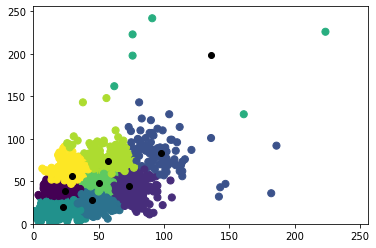

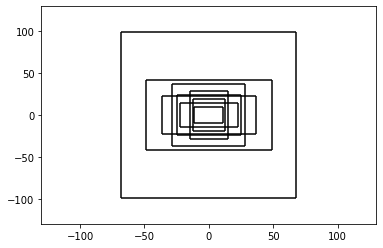

In [ ]:
anchor = ClusterAnchorsBox(join, 9)
ChartAnchorsBox(anchor)

## Tuning Gabungan Per Wilayah

Ukuran anchors box diperoleh dari gabungan anchors per wilayah. Tiap wilayah diclustering sebanyak 3 cluster, lalu ukuran tersebut digabungkan menjadi 9.

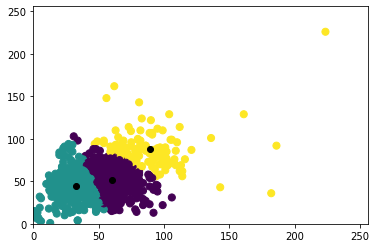

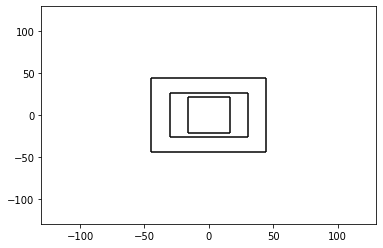

In [ ]:
anc_pondok = ClusterAnchorsBox(pondok_label, 3)
ChartAnchorsBox(anc_pondok)

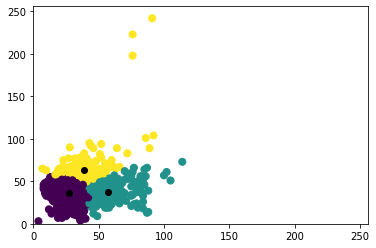

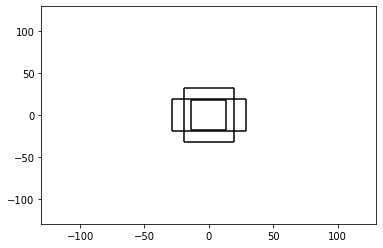

In [ ]:
anc_kembangan = ClusterAnchorsBox(kembangan_label, 3)
ChartAnchorsBox(anc_kembangan)

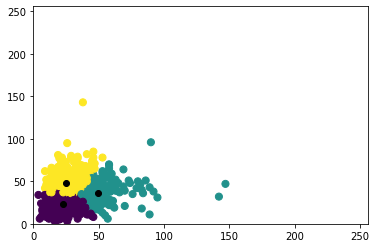

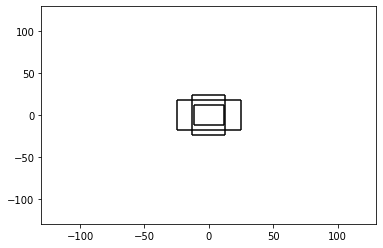

In [ ]:
anc_kampung = ClusterAnchorsBox(kampung_label, 3)
ChartAnchorsBox(anc_kampung)

Berikut titik pusat cluster gabungan dari tiap wilayah dna visualisasi anchors box nya.

In [ ]:
anchor_join = [i.tolist() for i in anc_kampung]
anchor_join.extend([i.tolist() for i in anc_kembangan])
anchor_join.extend([i.tolist() for i in anc_pondok])
np.around(anchor_join,0)

array([[23., 23.],
       [50., 36.],
       [25., 48.],
       [27., 37.],
       [57., 38.],
       [39., 64.],
       [60., 52.],
       [32., 44.],
       [90., 88.]])

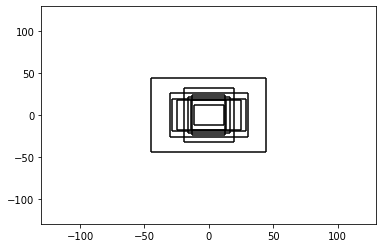

In [ ]:
ChartAnchorsBox(anchor_join)

Berikut perbandingan visualisasi anchors box dengan nilai default dan tuning seluruh wilayah. Dapat dilihat perbandingannya dengan tuning gabungan per wilayah pada gambar di atas.

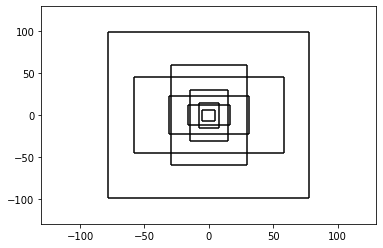

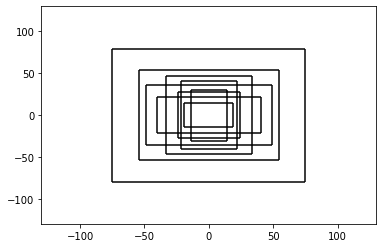

In [ ]:
baseline = [[10,13], [ 16,30],  [33,23],  [30,61],  [62,45],  [59,119],  [116,90],  [156,198],  [373,326]]
tuning = [[38,28],  [28,61],  [48,54],  [44,81],  [81,44],  [67,94],  [98,71], [109,107], [150,159]]

ChartAnchorsBox(baseline)
ChartAnchorsBox(tuning)